# Correlation of Temperature on any Day with Subsequent Days

In this file I read daily weather data for 2017 from Environment and Climate Change Canada for CYUL (Montreal-Trudeau Airport).

I want to show how the maximum temperature on a day is correlated with the max. temperature as days increase from the initial day i.e. D0 - D+1, D+2, D+3...

The expectation is that the correlation coefficient should decrease exponentially with increasing days up to a certain point.

Methods Used:
1. Read the data and drop null values
2. Create a day-shifted matrix of max. temps, with each column one day shifted forward
3. Find the correlation of the shifted matrix to give the correlation matrix
4. Plot the correlation against increasing day
5. Find a polynomial regression and plot through the data for a better visualisation

(Note: the correlation matrix table does not render in Github but can be viewed in colour through the <a href="https://nbviewer.jupyter.org/github/Callum-js/Plots_and_Analysis/blob/main/Temp_Regression/correlation_temperature_proceeding_days.ipynb">nbviwer</a> link.)

### Getting Started

- First I import the necessary packages.

- I then read in the datafile and select the daily Maximum Temperature data `Tmax`, while dropping the null values with `dropna`:

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
import seaborn as sns


df = pd.read_csv("Montreal_met_data.csv")


nf = df.loc[:, ["Tmax"]]
nf.dropna(inplace = True)



### Correlation Matrix

For the correlation matrix for Tmax from the initial day - D0 to D+1, D+2...D+N, I created a dataframe `sf` with columns as the `Tmax` values for D0...DN, with each column's values shifted by 1 day forward.  Each column had to be the same length, so I removed start end values depending on the day shifted number.

I defined a function `day_shift_matrix` to do this, so that values could be easily changed.

Within the function, I created a list of series `t` of the `Tmax` values. I then concatenated the list of series into a dataframe and renamed the columns.

In [21]:
def day_shift_matrix(t_series, n_days):
    """Takes in the pandas series of Tmax values, along with the number of days to shift the values by.
       Appends the Tmax values to a list, shifted from 0 to n days forward and matches the index of the original
       series, t0, so that the values are aligned. Returns the dataframe ready for correlation."""
    n = n_days
    t = []
    nf = t_series
    
    for i in range(n):
        t.append(nf[i:-n+i])
        t[i].set_index(t[i].index.values -i, inplace=True)
    
    sf = pd.concat(t, axis=1)

    cols=[]
    for i in range(n):
        cols.append(f"Tmax_d{i}")
    
    sf.columns = cols
    return sf


### Find Correlation Matrix

I now call the `day_shift_matrix` function and compute the correlation matrix using `corr()`.

A table of the `corr_matrix` can then be displayed using `style.background.gradient` and a colourmap from seaborn.

In [24]:
n = 8    #no. of days to include in correlation
shift_m = day_shift_matrix(t_series=nf, n_days=n)

corr_matrix = shift_m.corr()

cm = sns.light_palette("seagreen", as_cmap=True)
corr_table = corr_matrix.style.background_gradient(cmap=cm)
corr_table

,Tmax_d0,Tmax_d1,Tmax_d2,Tmax_d3,Tmax_d4,Tmax_d5,Tmax_d6,Tmax_d7
Tmax_d0,1.000000,0.925727,0.877994,0.856370,0.845665,0.841239,0.846359,0.840664
Tmax_d1,0.925727,1.000000,0.926154,0.878468,0.856403,0.844985,0.840993,0.846321
Tmax_d2,0.877994,0.926154,1.000000,0.926518,0.878427,0.856450,0.845709,0.842105
Tmax_d3,0.856370,0.878468,0.926518,1.000000,0.926137,0.878238,0.856981,0.846635
Tmax_d4,0.845665,0.856403,0.878427,0.926137,1.000000,0.927820,0.880821,0.860004
Tmax_d5,0.841239,0.844985,0.856450,0.878238,0.927820,1.000000,0.928717,0.882198
Tmax_d6,0.846359,0.840993,0.845709,0.856981,0.880821,0.928717,1.000000,0.929370
Tmax_d7,0.840664,0.846321,0.842105,0.846635,0.860004,0.882198,0.929370,1.000000


### Plotting Correlation Coefficient of Tmax values with Increasing Days

From the correlation matrix table above, the correlation coefficient of max. temperature decreases as expected with increasing days from the starting day. After about 4 days, the value levels off. This would be expected as temperatures on this time scale should tend to fluctuate either side of the seasonal mean, so after 5-7 days, the temperature should still be reasonably well correlated to the initial day.

To visualise how the correlation changes with increasing days from the inital day, I plotted a scatter of the correlation values.

I also performed a polynomial regression on these values in order to plot a best fit curve.

Here I use the method I learnt on the <a href="https://csmastersuh.github.io/data_analysis_with_python_spring_2020/linear_regression.html">University of Helsinki's Data Analysis with Python free online course</a>. 

For the regression, I used the `LinearRegression` class imported from `sklearn.linear`.  The Linear Regression can be used to perform a polynomial regression by adding more explanatory variables to the model.  In this case I performed a third order polynomial regression and so added the variables $x^{2}$: `x2` and $x^{3}$: `x3` to the model and concatenated these together.
 
 
I then fitted the x values and the y values (the first column of `corr_matrix`) to the model and plotted the best fit curve.


[Text(0, 0.5, 'Correlation Coefficient'),
 Text(0.5, 1.0, 'Correlation of Tmax with increasing days')]

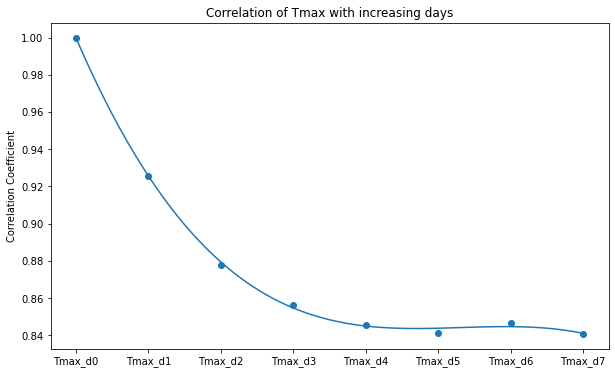

In [25]:
ind = np.arange(n)       #x values
idx = ind.reshape(-1,1)  #reshape into n rows, 1 col for the regression
x2 = idx**2
x3 = idx**3
y = corr_matrix.values[:,0]

model_cub = LinearRegression()                         #Create a Linear Regression model
model_cub.fit(np.concatenate([idx,x2,x3], axis=1),y)   #fit the x,x2,x3 and y values to the model

#Here I create x values on which to plot the regression polynomial values
x_fit = np.linspace(0,7, 71).reshape(-1,1)
#Extract the best fitting polynomial curve y values
y_fit_cub = model_cub.predict(np.concatenate([x_fit,x_fit**2,x_fit**3],axis=1))


fig, ax = plt.subplots(figsize = (10,6))
#Plot scatter of correlation values with day
ax.scatter(x = range(8), y= corr_matrix.values[:,0])
#Plot the polynomial regression curve
ax.plot(x_fit, y_fit_cub)

ax.set_xticks(range(8))
ax.set_xticklabels(shift_m.columns)
ax.set(ylabel="Correlation Coefficient",
       title="Correlation of Tmax with increasing days")